# Madgwick attitude estimator
## Main libraries import

In [1]:
%matplotlib inline
import numpy as np
from numpy import pi, sqrt

from blocksim.control.System import G6DOFSystem
from blocksim.control.IMU import IMU
from blocksim.control.SetPoint import Step
from blocksim.control.Estimator import MadgwickFilter
from blocksim.utils import deg, euler_to_quat

[INFO] - Registered blocksim.loggers.CSVLogger
[INFO] - Registered blocksim.loggers.PickleLogger
[WARNING] - Failed to load blocksim.loggers.PsqlLogger
[INFO] - Registered blocksim.loggers.XlsLogger


## Definition of a null Step function

In [2]:
from blocksim.control.SetPoint import Step

ctrl = Step(name="ctrl", snames=["u%i" % i for i in range(6)], cons=np.zeros(6))

## Definition of the dynamic system
Initialisation of a G6DOFSystem, rotating about the pitch axis

In [3]:
from blocksim.control.System import G6DOFSystem

sys = G6DOFSystem("sys")

angle_ini = -60 * np.pi / 180.0
wangle = 10.0 * np.pi / 180.0
x0 = np.zeros(13)
x0[10:13] = np.array([0.0, wangle, 0.0])
q = euler_to_quat(roll=0.0, pitch=angle_ini, yaw=pi / 2)
x0[6:10] = q
sys.setInitialStateForOutput(x0, "state")

## Initialisation of a biased and noisy IMU

In [4]:
from blocksim.control.IMU import IMU

imu = IMU(name="imu")
cov = np.diag(3 * [np.pi / 180] + 3 * [1e-3 * 9.81] + 3 * [1.0e-6])
imu.setCovariance(cov)
moy = np.zeros(9)
moy[0] = 0.5 * np.pi / 180
moy[1] = -1.0 * np.pi / 180
moy[2] = 1.5 * np.pi / 180
imu.setMean(moy)

## Initialisation of the Madgwick attitude estimator

In [5]:
from blocksim.control.Estimator import MadgwickFilter

est = MadgwickFilter("madg", beta=2.0)
est.setMagnetometerCalibration(offset=np.arange(3), softiron_matrix=np.eye(3) / 2)
b, m = est.getMagnetometerCalibration()
est.setMagnetometerCalibration(offset=np.zeros(3), softiron_matrix=np.eye(3))

## Simulation and plotting

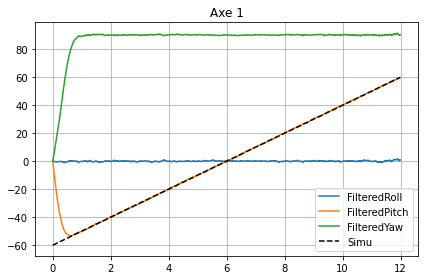

In [6]:
from blocksim.graphics import plotVerif
from blocksim.Simulation import Simulation
from matplotlib import pyplot as plt

sim = Simulation()

sim.addComputer(ctrl)
sim.addComputer(sys)
sim.addComputer(imu)
sim.addComputer(est)

sim.connect("ctrl.setpoint", "sys.command")
sim.connect("sys.state", "imu.state")
sim.connect("imu.measurement", "madg.measurement")

tfin = -2 * angle_ini / wangle
tps = np.arange(0.0, tfin, 1e-2)
w = angle_ini + tps * wangle

sim.simulate(tps, progress_bar=False)
log = sim.getLogger()

_ = plotVerif(
    log,
    "Figure 1",
    [
        {"var": "deg(madg_euler_roll)", "label": "FilteredRoll"},
        {"var": "deg(madg_euler_pitch)", "label": "FilteredPitch"},
        {"var": "deg(madg_euler_yaw)", "label": "FilteredYaw"},
        {
            "var": deg(w),
            "label": "Simu",
            "color": "black",
            "linestyle": "--",
        },
    ],
)